# Asymptotics

In [Example 01](./gmmfun-example-01-usage.ipynb), we saw some issues with the weight matrix $W$.  (See the README for GMM background and where $W$ comes into play.)  In particular, it seemed like we could run into issues when $W$ was ill-conditioned, a result of greatly differing variances in the moment conditions.  Also, the ellipticity of $W$ could matter.  Here we explore this matter further via checking the asymptotics.

Asymptotically speaking, we expect the $J$ function (see README), which is the functional that is being minimized to compute the estimator, to be $\chi^2$ distributed when working with an overdetermined system.  Implicit in that statement is that the weight matrix is chosen to be or is converging to the optimal weight matrix, which corresponds (proportionally) to the asymptotic variance of the moment conditions.

What we find below is that when we know the asymptotic variance or when we can compute it exactly from the estimate, then the asymptotics kick in fairly early.  If we estimate the asymptotic variance using data, then it can take a lot longer.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 3]

In [2]:
import jax.numpy as jnp
import progressbar
import numpy as np
from scipy.linalg import solve
from scipy.stats import norm, chi2

In [3]:
from gmmfun import GmmMgf4, GmmMgfAvar
from gmmfun.utils import moment_functions, mgf_avar

In [4]:
def plot_against_null(jstats, df, ngrid=100):
    fig, ax = plt.subplots(1, 1)
    grid = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), ngrid)
    ax.plot(grid, chi2(df=df).pdf(grid), 'k-', lw=2, label='frozen pdf')
    ax.hist(jstats, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
    return fig, ax

In [5]:
def mgf_norm(t, theta):
    return jnp.exp(t * theta[0] + 0.5 * jnp.square(theta[1] * t))

lower_bounds = jnp.array([-jnp.inf, 0.0])
upper_bounds = jnp.array([ jnp.inf, jnp.inf])
bounds_norm = (lower_bounds, upper_bounds)

In [6]:
rng = np.random.default_rng(12345)

In [7]:
NSAMP = 200
theta0 = np.array([1.0, 1.0])

## What is going to trip us up?

Let us restate the problem: estimating the asympototic variance.  Below we conduct a sampling exercise to show that 1) that it requires many samples just to get with 10% of the true value and 2) that $W$ has more error than $S$ on a relative basis.

We can make this comparison because the moment function can be used to compute the asymptotic variance for a given parameter value $\theta$.  Since we know $\theta = \theta_0$ the true parameter value, we can compute the true asympototic variance `S0`, and hence the optimal weight matrix `W0`.

In [8]:
def mgf_4_emp_S(theta0, size=10):
    x_a_lot = norm.rvs(loc=theta0[0], scale=theta0[1], size=size)
    mgf_4 = GmmMgf4(mgf_norm, bounds_norm, x_a_lot)
    mgf_4.theta = theta0
    mgf_4.update_W()
    foo = mgf_4.loss_components_expanded(theta0)
    S_emp = np.matmul(np.transpose(foo), foo) / foo.shape[0]
    S_emp = np.cov(np.transpose(foo))
    return S_emp, mgf_4.W

def rel_error(A, A0):
    return np.linalg.norm(A - A0) / np.linalg.norm(A0)

The true asympototic variance (scaled by n) and the corresponding weight matrix.

In [9]:
moment_functions_norm = moment_functions(mgf_norm, 8)

In [10]:
S0 = mgf_avar(moment_functions_norm, theta0)
S0

array([[  1.,   2.,   6.,  16.],
       [  2.,   6.,  18.,  56.],
       [  6.,  18.,  60., 192.],
       [ 16.,  56., 192., 664.]])

In [11]:
W0 = solve(S0, np.identity(4), assume_a = "pos")

Now we simulate to get the mean relative error for both across sample sizes of 100, 1000, and 10,000.

In [12]:
S_rel_error = np.zeros((NSAMP, 3))
W_rel_error = np.zeros((NSAMP, 3))
sample_sizes = np.array([100, 1000, 10000])
for j in progressbar.progressbar(range(NSAMP)):
    for i in range(3):
        S_emp, W_emp = mgf_4_emp_S(theta0, size=sample_sizes[i])
        S_rel_error[j,i] = rel_error(S_emp, S0)
        W_rel_error[j,i] = rel_error(W_emp, W0)

100% (200 of 200) |######################| Elapsed Time: 0:01:36 Time:  0:01:36


Below we see the mean relative error for $S$ and $W$.  We don't drop below 10% error for both until we have 10,000 samples.

In [13]:
np.mean(S_rel_error, axis=0), 

(array([0.53207708, 0.23169049, 0.07242943]),)

In [14]:
np.mean(W_rel_error, axis=0)

array([1.17035075, 0.2882419 , 0.09255543])

## When using the known asymptotic variance

The best case scenario is when we know the asymptotic variance.  Since we know the true parameter value, we do indeed know $S_0$, which we computed above.  In our simulation studies, 500 samples seems to suffice to recapitulate the expected asymptotic distribution.

We use `NSAMP` samples (set above) to generate the null for data of size `num_x`.

In [15]:
num_x = 200

In [16]:
pval_list = list()
jstat_list = list()
for i in progressbar.progressbar(range(NSAMP)):
    # print(i)
    x = rng.normal(loc=theta0[0], scale=theta0[1], size=num_x)
    theta_init = jnp.array([jnp.mean(x), jnp.std(x)])
    mgf_4_temp = GmmMgf4(mgf_norm, bounds_norm, x)
    mgf_4_temp.opt(theta_init, W0)
    pval_list.append(mgf_4_temp.pval)
    jstat_list.append(mgf_4_temp.jstat)
pvals_0 = np.array(pval_list)
jstats_0 = np.array(jstat_list)

100% (200 of 200) |######################| Elapsed Time: 0:02:12 Time:  0:02:12


We expect $J$ to be distributed $\chi^2_2$ in this case, which we use when computing the $p$-value.  We expect $p$ to be less than 0.05 5% of the time and $J$ to have a mean of 2, which is approximately the cose.

In [17]:
np.mean(pvals_0 <= 0.05), np.mean(jstats_0)

(0.045, 2.0048783)

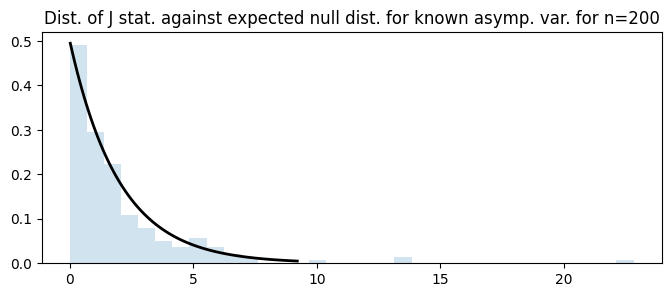

In [18]:
fig, ax = plot_against_null(jstats_0, df=2)
plt.title(f"Dist. of J stat. against expected null dist. for known asymp. var. for n={num_x}");

## Using the sample asymptotic variance

Now, instead of using the know best weight matrix $W_0$, we are using the data to estimate the weight matrix, as is suggested by the iterative approach for GMM.  Testing various sample sizes for `x`, we see that 200 samples seems to lead to a higher rejection rate that would be expected under the asymptotics, but that 2000 samples does a better job.

In [19]:
pval_list = list()
jstat_list = list()
for i in progressbar.progressbar(range(NSAMP)):
    # print(i)
    x = norm.rvs(loc=theta0[0], scale=theta0[1], size=200)
    theta_init = jnp.array([jnp.mean(x), jnp.std(x)])
    mgf_4_temp = GmmMgf4(mgf_norm, bounds_norm, x)
    mgf_4_temp.opt_I(theta_init)
    mgf_4_temp.update_both(5)
    pval_list.append(mgf_4_temp.pval)
    jstat_list.append(mgf_4_temp.jstat)
pvals_200 = np.array(pval_list)
jstats_200 = np.array(jstat_list)

100% (200 of 200) |######################| Elapsed Time: 0:06:34 Time:  0:06:34


In [20]:
np.mean(pvals_200 <= 0.05), np.mean(jstats_200)

(0.135, 3.082371)

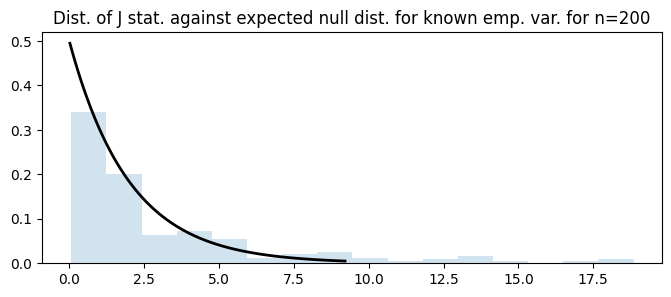

In [21]:
fig, ax = plot_against_null(jstats_200, df=2)
plt.title(f"Dist. of J stat. against expected null dist. for known emp. var. for n={200}");

In [22]:
pval_list = list()
jstat_list = list()
for i in progressbar.progressbar(range(NSAMP)):
    # print(i)
    x = norm.rvs(loc=theta0[0], scale=theta0[1], size=2000)
    theta_init = jnp.array([jnp.mean(x), jnp.std(x)])
    mgf_4_temp = GmmMgf4(mgf_norm, bounds_norm, x)
    mgf_4_temp.opt_I(theta_init)
    mgf_4_temp.update_both(5)
    pval_list.append(mgf_4_temp.pval)
    jstat_list.append(mgf_4_temp.jstat)
pvals_2000 = np.array(pval_list)
jstats_2000 = np.array(jstat_list)

100% (200 of 200) |######################| Elapsed Time: 0:06:28 Time:  0:06:28


In [23]:
np.mean(pvals_2000 <= 0.05), np.mean(jstats_2000)

(0.05, 1.9126024)

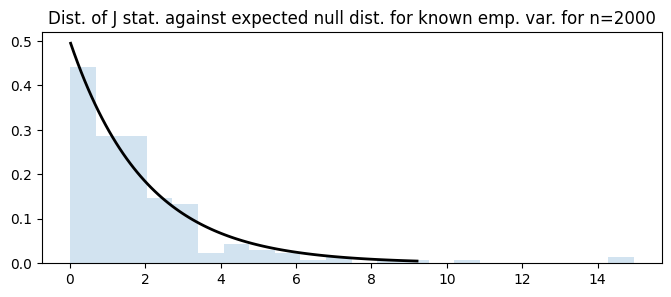

In [24]:
fig, ax = plot_against_null(jstats_2000, df=2)
plt.title(f"Dist. of J stat. against expected null dist. for known emp. var. for n={2000}");

## When updating the asymptotic variance as a function of $\theta$



In [25]:
# This may take a while
pval_list = list()
jstat_list = list()
for i in progressbar.progressbar(range(NSAMP)):
    # print(i)
    x = norm.rvs(loc=theta0[0], scale=theta0[1], size=200)
    theta_init = jnp.array([jnp.mean(x), jnp.std(x)])
    mgf_4_temp = GmmMgfAvar(mgf_norm, bounds_norm, 4, x)
    mgf_4_temp.opt(theta_init, W0)
    pval_list.append(mgf_4_temp.pval)
    jstat_list.append(mgf_4_temp.jstat)
pvals_avar = np.array(pval_list)
jstats_avar = np.array(jstat_list)

100% (200 of 200) |######################| Elapsed Time: 0:02:04 Time:  0:02:04


In [26]:
np.mean(pvals_avar <= 0.05), np.mean(jstats_avar)

(0.045, 1.9431047)

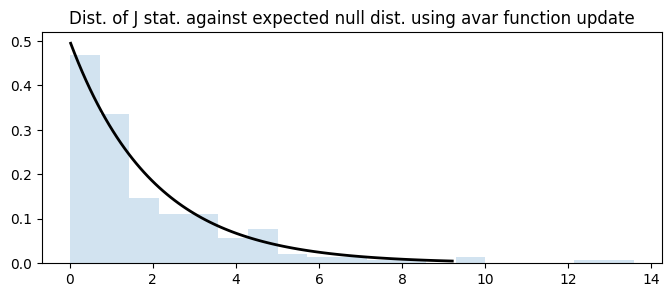

In [27]:
fig, ax = plot_against_null(jstats_avar, df=2)
plt.title(f"Dist. of J stat. against expected null dist. using avar function update");

## Is there an adjustment to make?

Lastly, and this is all speculation as I haven't found a clear answer on this, but...

If we return to the function $J_n$ from the README, there is a correspondence between $J_n$ and [Hotelling's](https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution#Hotelling_t-squared_statistic) $t$-squared statistic, which is
$$
t^2 = n \bar x ' \hat \Sigma^{-1} \bar x 
$$
where $\bar x \in \mathbb{R}^p$ is the $p$-dimensional sample mean, assumed to have mean zero, and $\hat \Sigma$ is the unbiased sample variance.  The distribution of $t^2$ when $x \sim N(0, \Sigma)$ is
$$
t^2 \sim p \frac{n-1}{n-p} F_{p, n-p}.
$$
Thus, replace $p$ with $q = K - L$, the amount by which we are overdetermined, which is like the degrees of freedom for the random variates $g(x_t, \theta)$, then one would expect something like
$$
\frac{n - q}{n q} \hat J_n \sim F_{q, n-q}.
$$
In the limit, this still results in a $\chi^2_q$ distribution for $J_n$.  But now, in a small sample size, we could account for the fact that $x$ is not normal by deflating $n$, which has the effect of enlarging the tails.

An example is below:

In [28]:
from scipy.stats import f as fdist

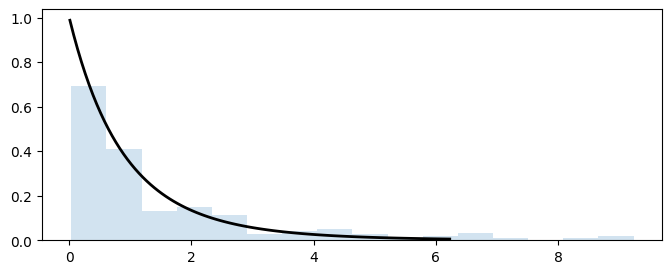

In [29]:
reduced_df = 16 # sqrt(n) seems to work
fig, ax = plt.subplots(1, 1)
fdist_obj = fdist(dfn=2, dfd=reduced_df)
grid = np.linspace(fdist_obj.ppf(0.01), fdist_obj.ppf(0.99), 100)
ax.plot(grid, fdist_obj.pdf(grid), 'k-', lw=2, label='frozen pdf')
ax.hist((100 - 2)/ (2 * 100) * jstats_200, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.show()

# Conclusion

To summarize, we have two choices when computing the asymptotic variance and corresponding optimal weight matrix.  We can use an empirical estimate of the asymptotic variance or we can use compute the asymptotic variance directly as a function of the current estimate.  Through our numerical experiments, we found that the functional approach seems to be more efficient.  However, that comes at a computational costs, since one must compute and evaluate higher order derivatives.